In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import json
from dotenv import load_dotenv
import os

load_dotenv()
MONGODB_URI = os.getenv("MONGODB_URI")

In [2]:
client = MongoClient(MONGODB_URI)
db = client["dev_v2"]
collection = db["edps_claims-837"]

docs = list(collection.find().limit(500))
print(f"Loaded {len(docs)} documents")

/tmp/ipykernel_84799/2618805189.py:1: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(MONGODB_URI)
/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/pymongo/synchronous/mongo_client.py:1758: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  self._resolve_srv()


Loaded 500 documents


In [3]:
def flatten_json(y, prefix=''):
    out = {}
    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], f'{name}{a}_')
        elif isinstance(x, list):
            i = 0
            for a in x:
                flatten(a, f'{name}{i}_')
                i += 1
        else:
            out[f'{name[:-1]}'] = x
    flatten(y, prefix)
    return out

flat_docs = [flatten_json(doc) for doc in docs]
df = pd.DataFrame(flat_docs)
print("Flattened dataframe shape:", df.shape)

Flattened dataframe shape: (500, 2390)


In [4]:
features = [
    "Provider_RenProv_Taxonomy",
    "Provider_BillProv_Taxonomy",
    "Provider_SvcFac_State",
    "Member_Subscriber_Gender",
    "Member_Subscriber_State",
    "Member_Subscriber_InsTypeCode",
    "Member_Subscriber_RelshipCode",
    "Claim_TotalAmt",
    "Claim_POS",
    "Claim_Frequency",
    "ServiceLine_0_BilledCPT_Code",
]

target = "Diagnosis_Diag_Codes_0_Diagnosis_01"

df = df[features + [target]].dropna(subset=[target])
df[target] = df[target].astype(str)

In [5]:
numeric_fields = ["Claim_TotalAmt", "Claim_POS", "Claim_Frequency"]

for col in numeric_fields:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.extract(r"(\d+\.?\d*)")[0]  # extract numeric part only
        .astype(float)
    )

# Treat missing or invalid numeric values as 0
df[numeric_fields] = df[numeric_fields].fillna(0)

# Convert categorical fields to string
for col in df.columns:
    if col not in numeric_fields + [target]:
        df[col] = df[col].astype(str).fillna("Unknown")

print(f"Final dataset shape: {df.shape}")
print(f"Target class count: {df[target].nunique()} unique diagnoses")

Final dataset shape: (497, 12)
Target class count: 299 unique diagnoses


In [6]:
X = df[features]
y = df[target]

# Drop extremely rare classes (occur once)
y_counts = y.value_counts()
rare_classes = y_counts[y_counts < 2].index
mask = ~y.isin(rare_classes)

X = X[mask]
y = y[mask]

cat_cols = [col for col in features if col not in numeric_fields]
num_cols = numeric_fields

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

Categorical: ['Provider_RenProv_Taxonomy', 'Provider_BillProv_Taxonomy', 'Provider_SvcFac_State', 'Member_Subscriber_Gender', 'Member_Subscriber_State', 'Member_Subscriber_InsTypeCode', 'Member_Subscriber_RelshipCode', 'ServiceLine_0_BilledCPT_Code']
Numerical: ['Claim_TotalAmt', 'Claim_POS', 'Claim_Frequency']


In [7]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    random_state=42
)

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", tree)
])


In [13]:
y_counts = y.value_counts()
rare_classes = y_counts[y_counts >= 5].index 
mask = ~y.isin(rare_classes)

X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)


=== Classification Report ===
              precision    recall  f1-score   support

        C250       0.00      0.00      0.00         2
         C61       0.00      0.00      0.00         0
        D509       0.00      0.00      0.00         1
        E042       0.00      0.00      0.00         2
        E785       0.00      0.00      0.00         1
        E851       0.00      0.00      0.00         1
        F411       0.00      0.00      0.00         1
        G629       0.00      0.00      0.00         1
       G9340       0.00      0.00      0.00         2
       H2512       0.00      0.00      0.00         1
        I499       0.00      0.00      0.00         1
       I6200       0.00      0.00      0.00         1
        I739       0.00      0.00      0.00         0
       K8590       0.00      0.00      0.00         2
       M1711       0.00      0.00      0.00         1
      M25512       0.00      0.00      0.00         1
      M25539       0.00      0.00      0.00       

/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="

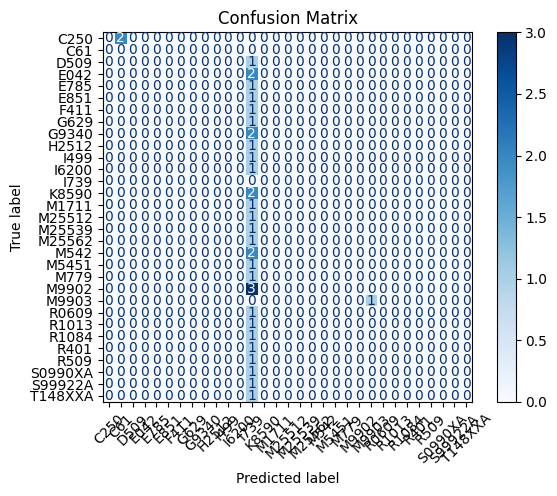

In [14]:
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

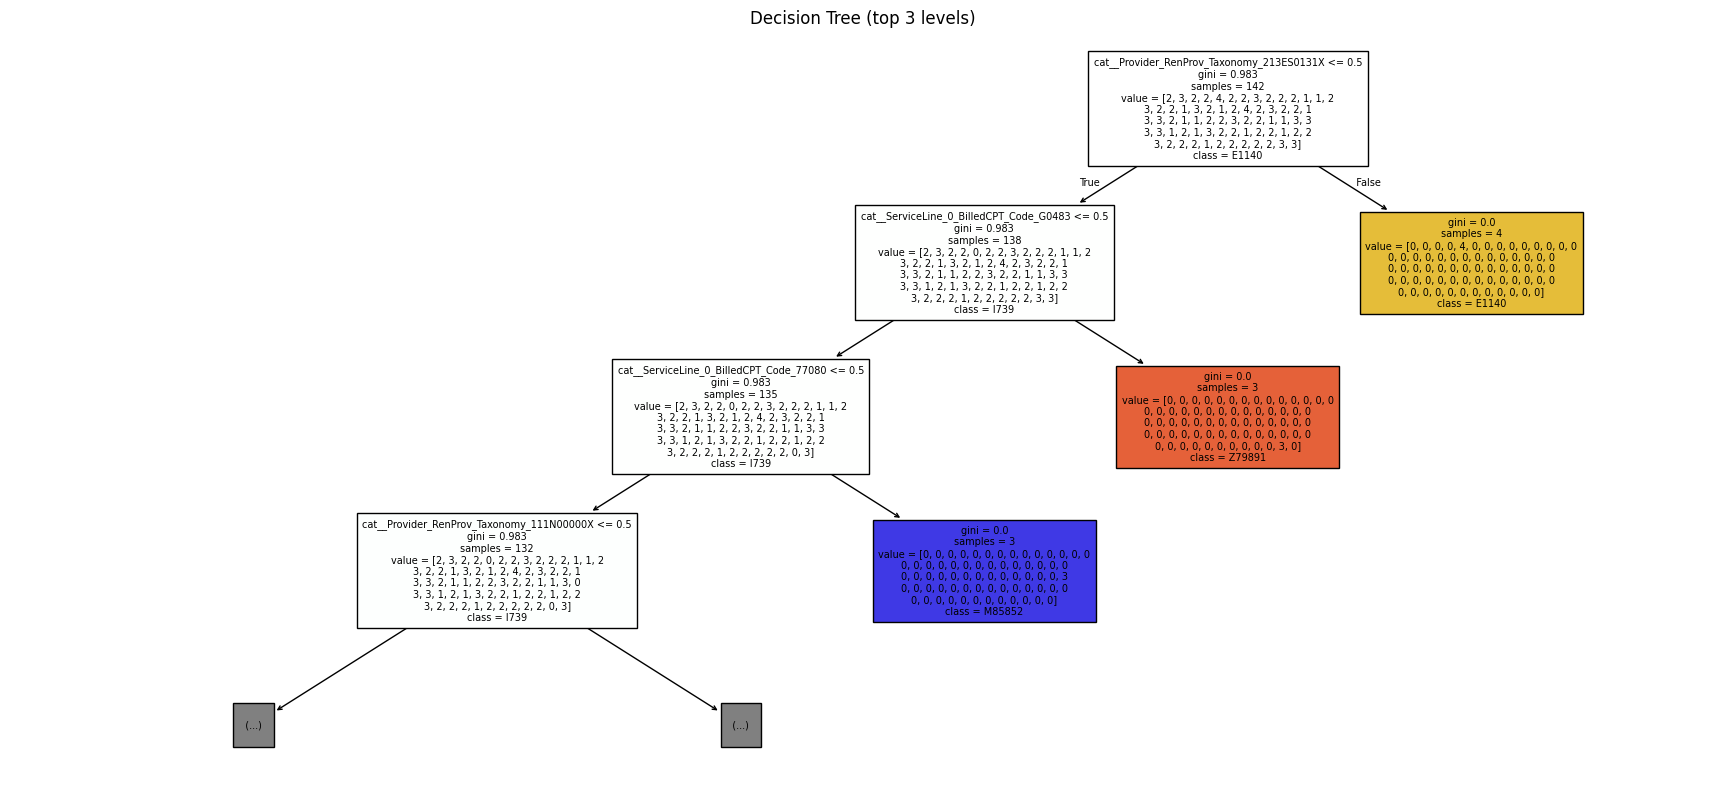

In [15]:
fitted_tree = model.named_steps["clf"]
preprocessor = model.named_steps["preprocess"]

encoded_features = preprocessor.get_feature_names_out()
plt.figure(figsize=(22, 10))
plot_tree(
    fitted_tree,
    feature_names=encoded_features,
    class_names=np.unique(y_train),
    filled=True,
    fontsize=7,
    max_depth=3
)
plt.title("Decision Tree (top 3 levels)")
plt.show()

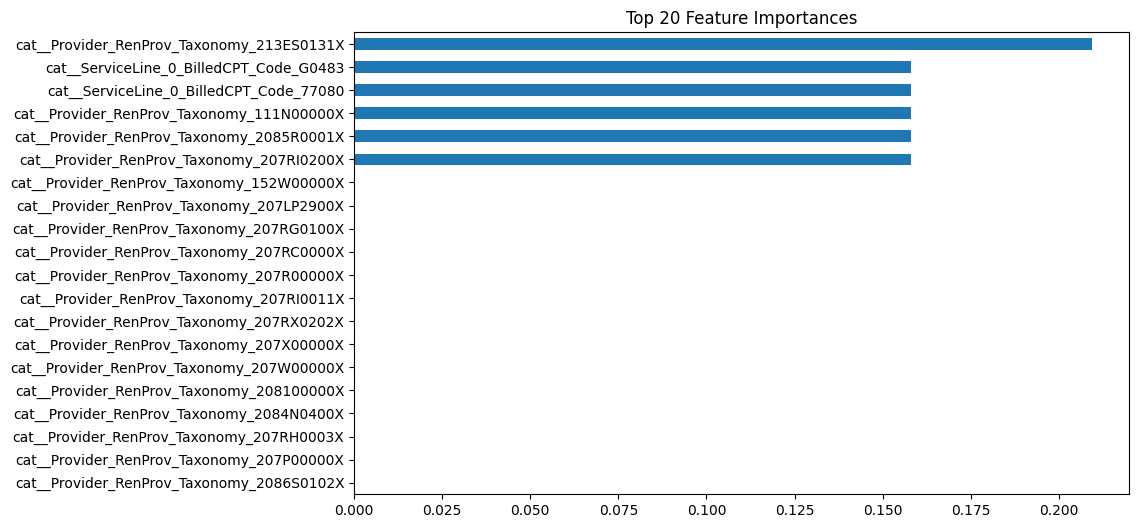

In [16]:
importances = pd.Series(
    fitted_tree.feature_importances_,
    index=encoded_features
).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
importances.plot(kind="barh")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [17]:
joblib.dump(model, "diagnosis_tree_model.joblib")
print("Model saved to diagnosis_tree_model.joblib")

Model saved to diagnosis_tree_model.joblib


In [18]:
sample = X_test.iloc[[0]]
pred_diag = model.predict(sample)[0]
print("\nSample input:")
print(sample)
print("Predicted Diagnosis Code:", pred_diag)


Sample input:
   Provider_RenProv_Taxonomy Provider_BillProv_Taxonomy Provider_SvcFac_State  \
78                       nan                        nan                    FL   

   Member_Subscriber_Gender Member_Subscriber_State  \
78                        M                      WA   

   Member_Subscriber_InsTypeCode Member_Subscriber_RelshipCode  \
78                            47                            18   

    Claim_TotalAmt  Claim_POS  Claim_Frequency ServiceLine_0_BilledCPT_Code  
78            43.0       21.0              1.0                        73630  
Predicted Diagnosis Code: I739
